In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os

In [2]:
os.environ["JAX_ENABLE_X64"] = "True"

In [3]:
import jax
import jax.numpy as jnp
from jax import random as jax_random

key_random = jax.random.key(12)

In [4]:
import optax

In [5]:
print(f"Jax version {jax.__version__}")

Jax version 0.4.28


In [6]:
jax_scalar = jnp.array(3.14)
jax_vector = jnp.array([1, 2, 3, 4])
jax_matrix = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
jax_tensor3d = jnp.array(
    [
        [[1, 2, 3], [4, 5, 6]],
        [[7, 8, 9], [10, 11, 12]],
        [[13, 14, 15], [16, 17, 18]],
        [
            [19, 20, 21],
            [22, 23, 24],
        ],
    ]
)

In [7]:
print(jax_scalar.shape)
print(jax_vector.shape)
print(jax_matrix.shape)
print(jax_tensor3d.shape)

()
(4,)
(4, 2)
(4, 2, 3)


In [8]:
x_jax_32 = jax_random.normal(key_random, shape=(4, 4), dtype=jnp.float32)
print(x_jax_32.dtype)
print(x_jax_32)

float32
[[ 0.29981548  1.0307399   0.64020723 -1.5756007 ]
 [ 2.16129     0.2117739  -2.0117774  -0.2535699 ]
 [ 1.5561429   1.4858311   0.18778    -1.4641176 ]
 [-0.93344206 -2.3797116  -0.04247228 -0.8265378 ]]


In [9]:
x_jax_64 = jnp.asarray(x_jax_32, dtype=jnp.float64)
print(x_jax_32.dtype, x_jax_64.dtype)

float32 float64


In [10]:
b_np = x_jax_64 > 0.5
print(b_np)
print(b_np.dtype)

[[False  True  True False]
 [ True False False False]
 [ True  True False False]
 [False False False False]]
bool


In [11]:
jnp.sum(x_jax_32)

Array(-1.9136487, dtype=float32)

In [12]:
jnp.transpose(x_jax_32)

Array([[ 0.29981548,  2.16129   ,  1.5561429 , -0.93344206],
       [ 1.0307399 ,  0.2117739 ,  1.4858311 , -2.3797116 ],
       [ 0.64020723, -2.0117774 ,  0.18778   , -0.04247228],
       [-1.5756007 , -0.2535699 , -1.4641176 , -0.8265378 ]],      dtype=float32)

In [13]:
x_jax_32.T

Array([[ 0.29981548,  2.16129   ,  1.5561429 , -0.93344206],
       [ 1.0307399 ,  0.2117739 ,  1.4858311 , -2.3797116 ],
       [ 0.64020723, -2.0117774 ,  0.18778   , -0.04247228],
       [-1.5756007 , -0.2535699 , -1.4641176 , -0.8265378 ]],      dtype=float32)

In [14]:
print(jnp.transpose(jax_tensor3d, axes=[2, 1, 0]).shape)

(3, 2, 4)


In [15]:
# TODO: change device

<Axes: >

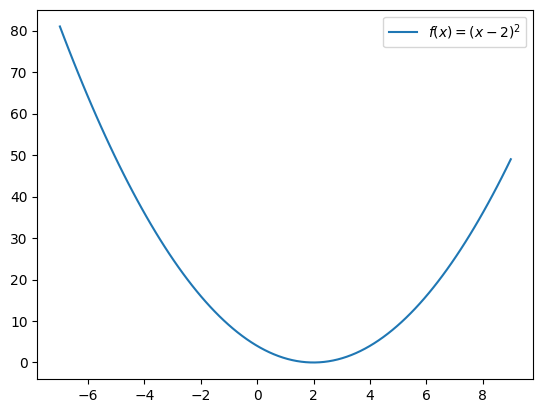

In [16]:
def f(x):
    return jnp.pow((x - 2.0), 2)


x_axis_vals = jnp.linspace(-7, 9, 100)
y_axis_vals = f(jnp.array(x_axis_vals))

sns.lineplot(x=x_axis_vals, y=y_axis_vals, label="$f(x)=(x-2)^2$")

<Axes: >

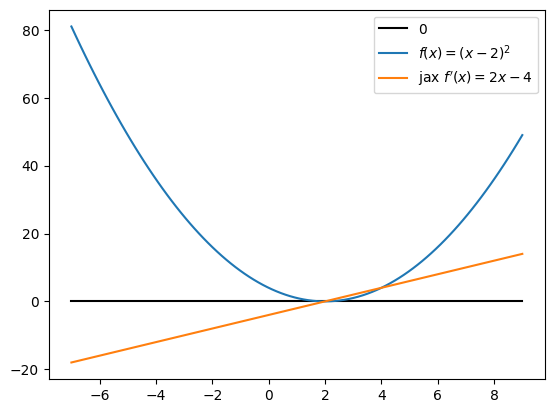

In [17]:
def fP(x):  # Defining the derivative of f(x) manually
    return 2 * x - 4


jax_grad_fP = jax.vmap(jax.grad(f))

y_axis_vals_p = fP(jnp.array(x_axis_vals))
y_axis_vals_p_jax = jax_grad_fP(jnp.array(x_axis_vals))

# First, lets draw a black line at 0, so that we can easily tell if something is positive or negative
sns.lineplot(x=x_axis_vals, y=[0.0] * len(x_axis_vals), label="0", color="black")
sns.lineplot(x=x_axis_vals, y=y_axis_vals, label="$f(x) = (x-2)^2$")

# sns.lineplot(x=x_axis_vals, y=y_axis_vals_p, label="$f'(x)=2 x - 4$")
sns.lineplot(x=x_axis_vals, y=y_axis_vals_p_jax, label="jax $f'(x)=2 x - 4$")

In [18]:
x = jnp.array([-3.5])

x_cur = x.clone()
x_prev = x_cur * 100  # Make the initial "previous" solution larger
epsilon = 1e-8
eta = 0.1

grad_f = jax.vmap(jax.grad(f))
while jnp.linalg.norm(x_cur - x_prev) > epsilon:
    x_prev = x_cur.clone()
    x_cur = x_cur - eta * grad_f(x_cur)

print(x_cur)

[1.99999996]


In [19]:
optimizer = optax.sgd(eta)

# Initialize parameters of the model + optimizer.
x_param = jnp.array(-3.5)
opt_state = optimizer.init(x_param)
grad_f = jax.grad(f)

for epoch in range(60):
    g = grad_f(x_param)
    updates, opt_state = optimizer.update(g, opt_state)
    x_param = optax.apply_updates(x_param, updates)
print(x_param)

1.9999915712745253
